#  **Testing Gaussian EP on a given RBM**


In [1]:
using Pkg
using Plots
using Revise
using DelimitedFiles
using BenchmarkTools

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/disat/amuntoni/.julia/packages/Revise/9lZUE/src/packagedef.jl:1369


In [2]:
Pkg.activate("../Sampling/")
using Sampling
Pkg.activate("../../GaussianEP/")
using GaussianEP

  Activating environment at `~/GaussianEP/Sampling/Project.toml`
  Activating environment at `~/GaussianEP/Project.toml`


In [3]:
# Number of visible and hidden units, Gaussian weigths
N = 8
M = 3
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

# (Pv, Ph) = (Gaussian - Gaussian) priors

In [4]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = GaussianEP.GaussianPrior(μv, βv, 0.0) 
Ph = GaussianEP.GaussianPrior(μh, βh, 0.0) 

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);

In [5]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 100);

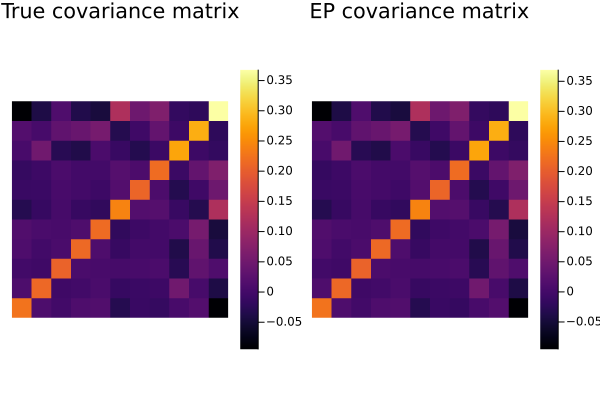

In [6]:
using Plots

Σan = GaussianEP.compute_analytic(w,[Pv for i = 1:N], [Ph for i = 1:M])
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out[1].state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
Plots.plot(p1,p2)

# (Pv, Ph) = (Binary - Gaussian) priors

In [7]:
x0v = 0.0; x1v = 1.0; ρ = 0.9;
μh = 0.5; βh = 3.0; 
Pv = GaussianEP.BinaryPrior(x0v, x1v, ρ)
Ph = GaussianEP.GaussianPrior(μh, βh, 0.0)

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);

In [8]:
out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-7, maxiter=100000);
cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end

it: 100 Δav: 1.2410174543564523e-6 Δgrad: 0.0


In [9]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, [Pv for i = 1:N], [Ph for i = 1:M]);

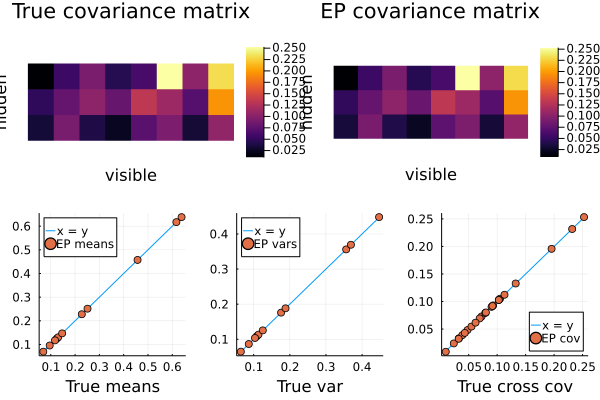

In [10]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [11]:
Pv = Sampling.BinaryPrior(x0v, x1v, ρ) 
Ph = Sampling.GaussianPrior(μh, βh, 0.0)
P0mc = vcat([Pv for i = 1:N],[Ph for i = 1:M]);

 23.357973 seconds (220.55 M allocations: 12.547 GiB, 26.59% gc time, 2.48% compilation time)


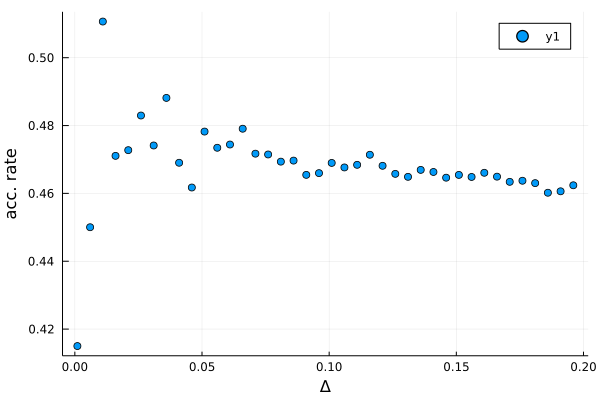

In [12]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.005:0.2)
@time acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

  1.102443 seconds (1.54 M allocations: 101.365 MiB, 5.21% gc time, 98.68% compilation time)


┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/disat/amuntoni/.julia/packages/Plots/S2aH5/src/args.jl:1262


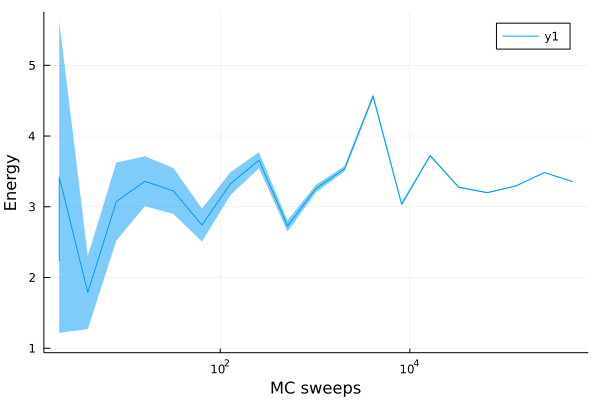

In [13]:
# Get thermalization time

Δ = 0.05
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
@time bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log, xlabel="MC sweeps", ylabel="Energy") 
plot(p1)


In [14]:
# Sampling using MCMC
bl_tab = nothing
Nconf = 10^6
Twait = 10^6
@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

 11.858822 seconds (110.37 M allocations: 6.360 GiB, 29.02% gc time, 3.85% compilation time)


In [15]:
# Compute statistics

@time av_mc, va_mc, cov_mc, _ = Sampling.compute_statistics(mc_out, N, M);

  1.440563 seconds (407 allocations: 1.498 GiB, 11.92% gc time)


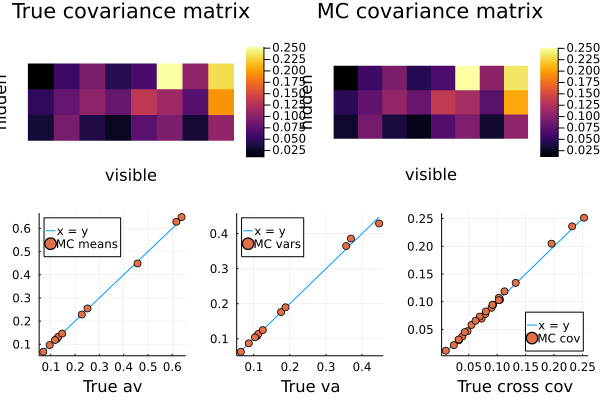

In [16]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [17]:

# Number of visible and hidden units, Gaussian weigths
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
θ = 1.0
μv = 0.0; βv = 10.0; # βv needs to be large

Pv = GaussianEP.GaussianPrior(μv, βv, 0.0)
Ph = GaussianEP.ReLUPrior(γ, θ, 1e-2, 0.0)

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);

In [18]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 50, epsconv = 1e-5, maxiter = 100000)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end

it: 50 Δav: 3.378175445720166e-5 Δgrad: 4.757532381205465e-5


In [19]:
γ_m = Ph.γ
θ_m = Ph.θ
println(γ_m, " ", θ_m)

50.02522300129718 1.0


In [20]:
Pv = Sampling.GaussianPrior(μv, βv, 0.0) 
Ph = Sampling.ReLUPrior(γ_m, θ_m) 

P0mc = vcat([Pv for i=1:N], [Ph for i = 1:M]);

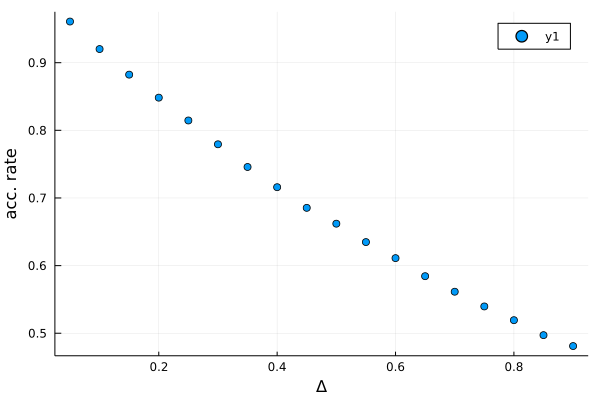

In [21]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.05:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/disat/amuntoni/.julia/packages/Plots/S2aH5/src/args.jl:1262


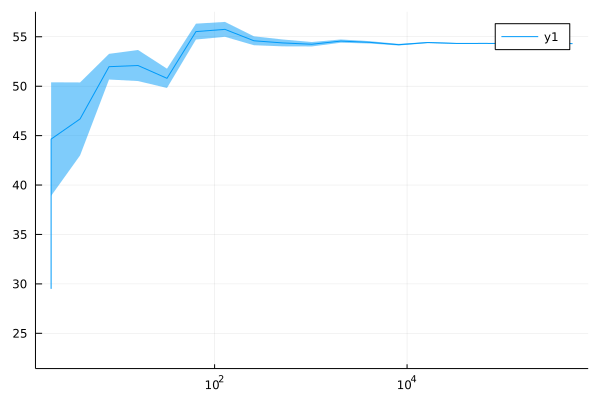

In [22]:

# Get thermalization time

Δ = 0.8
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [23]:
# Sampling using MCMC

mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.8
Nconf = 5 * 10^5
Twait = 10^4

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [24]:
# Compute statistics

av_mc, va_mc, cov_mc, _ = Sampling.compute_statistics(mc_out, N, M);

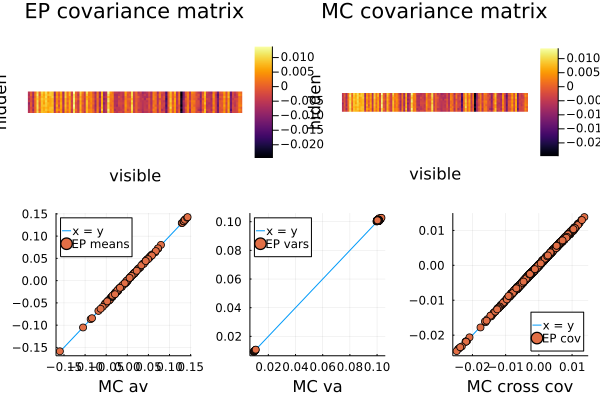

In [25]:

p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (SpikeAndSlab, ReLu) priors

In [26]:

# Number of visible and hidden units, Gaussian weigths
N = 30
M = 15
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
ρ = 1.0/21
λ = 50.0
Pv = GaussianEP.SpikeSlabPrior(ρ, λ, 0.0, 1e-3)
Ph = GaussianEP.ReLUPrior(γ, 0.0, 1e-3, 1e-3) 

P0 = vcat([Pv for i =1:N], [Ph for i = 1:M]);


In [27]:

out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-5, nprint = 100)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end


In [28]:
γ_m = Ph.γ
θ_m = Ph.θ
λ_m = Pv.λ
println("γ: ",γ_m, " θ: ", θ_m, " λ: ", λ_m)
Pv = Sampling.SpikeSlabPrior(ρ, λ_m) 
Ph = Sampling.ReLUPrior(γ_m, θ_m)
P0mc = vcat([Pv for i=1:N],[Ph for i = 1:M]);

γ: 50.00318247852452 θ: 0.0005229551068783982 λ: 49.99999021040592


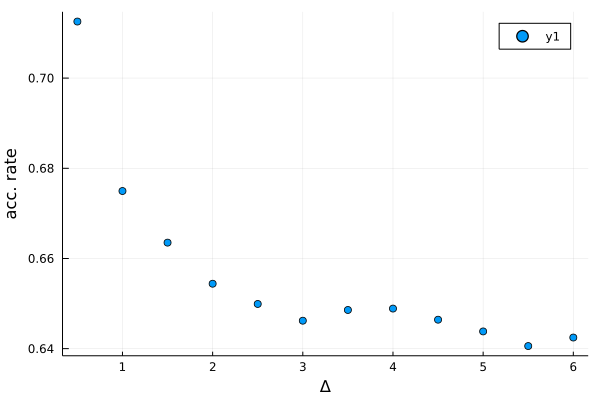

In [29]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.5:0.5:6.0)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/disat/amuntoni/.julia/packages/Plots/S2aH5/src/args.jl:1262


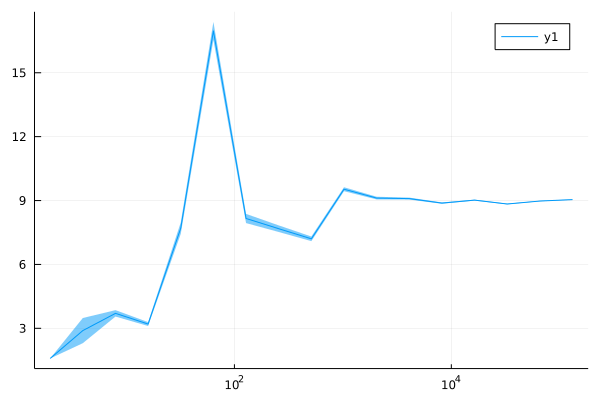

In [30]:
# Get thermalization time

Δ = 3.5
nblocks = 18
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [31]:
# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 3.5
Nconf = 5*10^6
Twait = 10^5

@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

157.254589 seconds (1.30 G allocations: 124.790 GiB, 13.68% gc time)


In [32]:
# Compute statistics

@time av_mc, va_mc, cov_mc, _ = Sampling.compute_statistics(mc_out, N, M);

106.428880 seconds (5.59 k allocations: 104.048 GiB, 7.49% gc time)


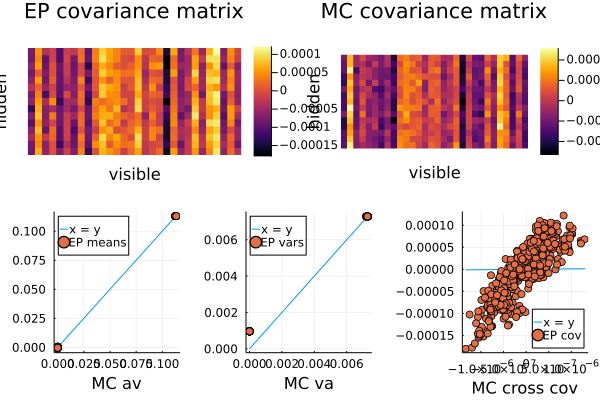

In [33]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, Spike and Slab)

In [34]:

# Number of visible and hidden units, Gaussian weigths
N = 30
M = 15
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
ρ = 0.2
λ = 20.0
μv = 0.5
βv = 50.0

Ph = GaussianEP.SpikeSlabPrior(ρ, λ)
Pv = GaussianEP.GaussianPrior(μv, βv, 0.0) 

P0 = vcat([Pv for i =1:N], [Ph for i = 1:M]);


In [35]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 100);

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end

In [36]:
Ph = Sampling.SpikeSlabPrior(ρ, λ)
Pv = Sampling.GaussianPrior(μv, βv, 0.0)
P0mc = vcat([Pv for i=1:N],[Ph for i = 1:M]);

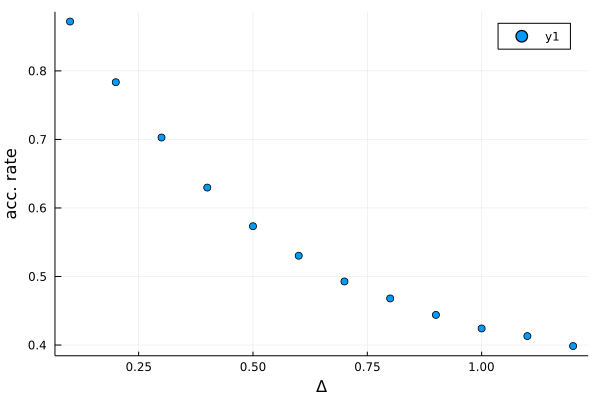

In [37]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.1:0.1:1.2)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/disat/amuntoni/.julia/packages/Plots/S2aH5/src/args.jl:1262


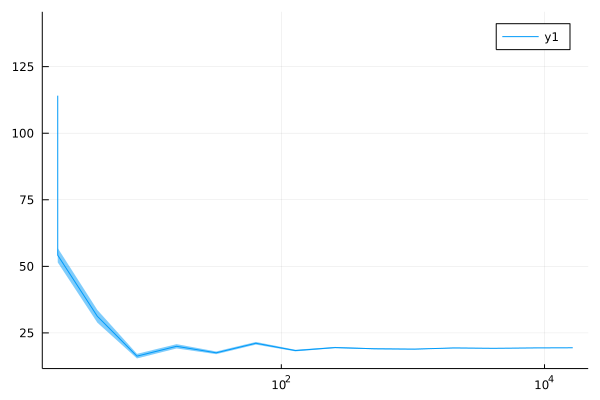

In [38]:
# Get thermalization time

Δ = 0.5
nblocks = 15
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:

# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Nconf = 5*10^6
Twait = 10^5

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

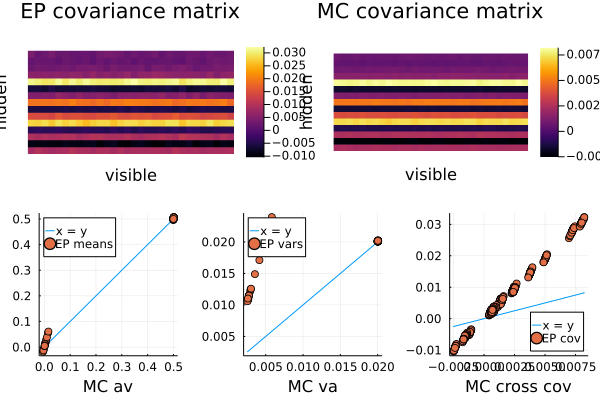

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)